In [1]:
rootF = 'D:/Data/Paper defocus/'

In [2]:
import os as os
import sys
import numpy as np
import csv
import pickle as pickle
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as pcs
from matplotlib.colors import ListedColormap
from skimage.transform import rescale, resize, downscale_local_mean
import seaborn as sns
from matplotlib.patches import Ellipse

# Import functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_scale_bar, load_image_as_on_MEA
from shared.LSC_functions import local_spatial_contrast, receptive_field
from shared.save_load import load_obj, save_obj

# Load data

In [3]:
simulation = 'Rem20240425_HumanSA_nufft_+4DAcc' 

imF = rootF + '/Eye model simulations/convolved images/' + str(simulation) + '/'

path_to_PSFs = rootF + '/Eye model simulations/emmetropic human PSFs/' + str(simulation) + '/'

##### Simulation parameters

In [4]:
# Simulation parameters

# Load job ids and optical conditions
simulation_parameters = pd.read_csv(path_to_PSFs + 'JMfile.csv', sep=";")
JobIds = simulation_parameters['JobId'].values

# eye SA
eye_SA_all = simulation_parameters['c04tg'].values
eye_SAs = np.unique(eye_SA_all)
# pup diams
pup_diam_all = simulation_parameters['pupDiam_mm'].values
pup_diams = np.unique(pup_diam_all)
# source eccentricity
sources_ecc_all = simulation_parameters['sourceEccen_deg'].values
sources_ecc = np.unique(sources_ecc_all)
# foveal defocus
offset_file = pd.read_csv(path_to_PSFs + 'offset.csv', sep=";")
offset_um = offset_file['offset_um'].values
offset_um_idx = offset_file['Index'].values
# focus proximity in diopter
focus_proximity_all = simulation_parameters['proximity'].values
focus_proximity = np.unique(focus_proximity_all)

print (len(JobIds), 'jobs in simulation', simulation)
print ('Pup diams:', pup_diams)
print ('Source ecc:', sources_ecc)
print ('Foveal defocus um:', offset_um)
print ('Focus proximity:', focus_proximity)
print ('SAs:', eye_SAs)

Ndfs = len(offset_um)
Npup = len(pup_diams)
NsrcEcc = len(sources_ecc)
Nprox = len(focus_proximity)
NSA = len(eye_SAs)

# Original images
Imgs = ['1','2','3','5']
Nimgs = len(Imgs)

120 jobs in simulation Rem20240425_HumanSA_nufft_+4DAcc
Pup diams: [3 5 7]
Source ecc: [ 0 10 20 30]
Foveal defocus um: [-600 -540 -480 -420 -360 -300 -240 -180 -120  -60    0   60  120  180
  240  300  360  420  480  540  600]
Focus proximity: [2.5 4. ]
SAs: [0.    0.038 0.076 0.108 0.18 ]


# Define a receptive field and measure LSC

In [5]:
FovDefocus_indices = np.arange(0,21,1) #np.arange(6,15,1)

print (offset_um[FovDefocus_indices])

[-600 -540 -480 -420 -360 -300 -240 -180 -120  -60    0   60  120  180
  240  300  360  420  480  540  600]


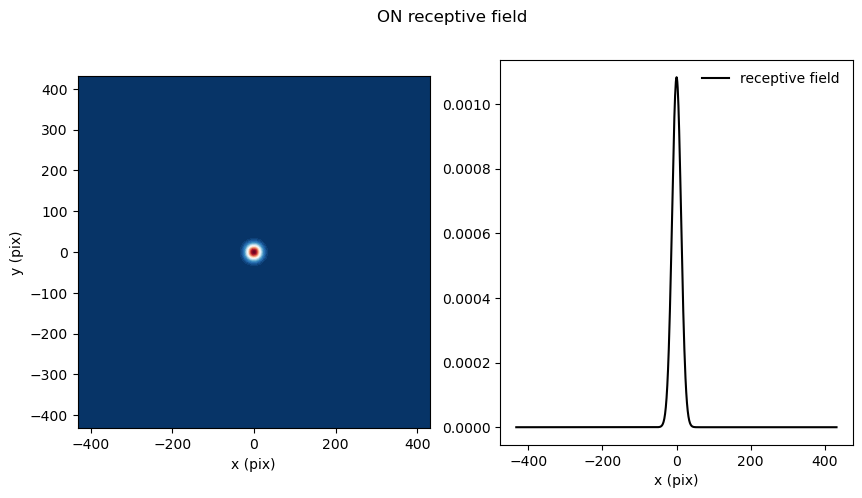

In [6]:
iPup = 1
img_size = 864
pixel_size = 3.5 
sigma_RFcenters = [60] # um, diameter is 2 times larger

local_contrasts = np.empty((len(sigma_RFcenters), Nimgs, NSA, Nprox, NsrcEcc, Ndfs))
mean_intensities = np.empty((len(sigma_RFcenters), Nimgs, NSA, Nprox, NsrcEcc, Ndfs))

for i, sigma_center_um in enumerate(sigma_RFcenters):
    
    ### Define a 2D gaussian for the RF weights
    sigma_RFcenter = sigma_center_um/pixel_size  # pixels
    filter_size = img_size # pix

    x, y, RFcenter, _, _ = receptive_field(0, sigma_RFcenter, 1, filter_size, 0, 0, plotting=True)
    RFcenter = RFcenter/np.amax(abs(RFcenter))
    
    ### Get the points containes in the RF
    xy_rf = (img_size/2, img_size/2)
    radius = sigma_RFcenter * 2 # 2 sigma contour
    rf = pcs.Circle(xy_rf, radius = radius, fill=False, color='r', lw=2)

    # calculate the x and y points possibly within the ellipse
    y_int = np.arange(0, img_size, 1)
    x_int = np.arange(0, img_size, 1)

    # create a list of possible coordinates
    g = np.meshgrid(x_int, y_int)
    coords = list(zip(*(c.flat for c in g)))

    # create the list of valid coordinates (from untransformed)
    RFpoints = np.vstack([p for p in coords if rf.contains_point(p, radius=0)])
    RFweights = RFcenter[RFpoints[:,1], RFpoints[:,0]]
        
    ### Measure LSC
    for iImg in range(Nimgs):
        for iSA in [0,2,4]:
            for iProx in range(Nprox):
                for iEcc in range(NsrcEcc):
                    for iDf in FovDefocus_indices: #range(Ndfs):
                        df = offset_um[iDf]
    #                         print (Imgs[iImg], focus_proximity[iProx], pup_diams[iPup], sources_ecc[iEcc], df)
                        # load blurred image
                        im = plt.imread(imF + 'image_{}pupDiam={}_dF={}_Source{}_focusProx={}.png'\
                                            .format(Imgs[iImg],pup_diams[iPup], str(round(df)), sources_ecc[iEcc], focus_proximity[iProx]))
    #                         print (im[350:400, 500:550])

                        mean_int, loc_contr = local_spatial_contrast(im, RFpoints, RFweights)

                        mean_intensities[i,iImg,iProx,iEcc,iDf] = mean_int
                        local_contrasts[i,iImg,iProx,iEcc,iDf] = loc_contr

In [7]:
### Save predictions
save_path = rootF + '/contrast analysis/' + simulation + '_'
                
save_obj(local_contrasts, save_path + 'local_contrast_2sigma_liu2022')

save_obj(mean_intensities, save_path + 'mean_intensities_2sigma_liu2022')

# Plots

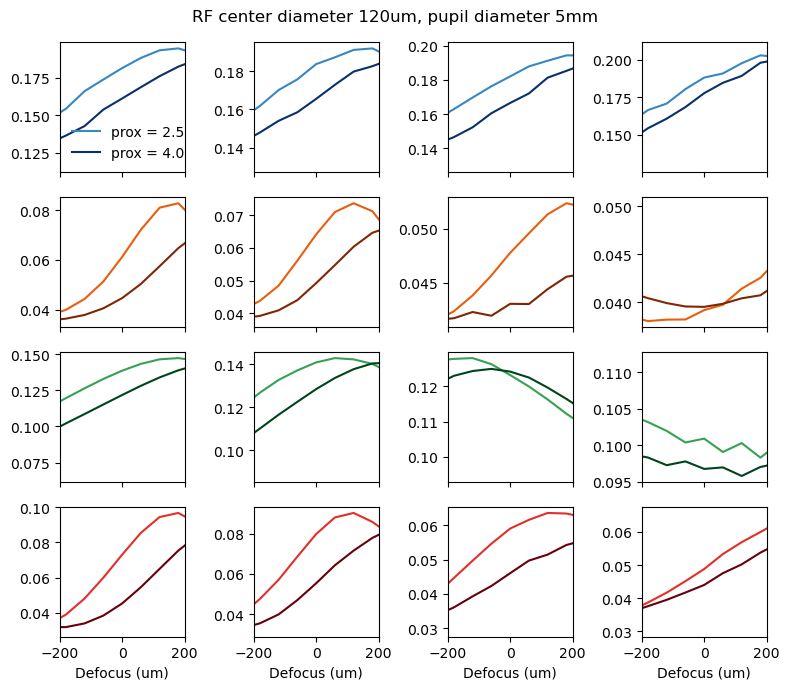

In [13]:
cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']

iCen = 0
iPup = 1

fig = plt.figure(figsize=(8,7))
fig.suptitle('RF center diameter {}um, pupil diameter {}mm'.format(2*sigma_RFcenters[iCen], pup_diams[iPup]))
GS = fig.add_gridspec(NsrcEcc,Nimgs)

loc_contr_min = 0.15 #0.95*amin(local_contrasts[iCen,:,iProx,:,:,:])
loc_contr_max = 0.25 #1.05*amax(local_contrasts[iCen,:,iProx,:,:,:])

for iEcc in range(NsrcEcc):
    for iImg in range(Nimgs):
        # cmap
        cmap = plt.get_cmap(cmaps[iImg])
        colors = [cmap(i) for i in np.linspace(0, 1, Nprox+2)]

        ### Local contrast vs defocus
        ax = fig.add_subplot(GS[iImg, iEcc])
        for iProx in range(Nprox):
            ax.plot(offset_um, local_contrasts[iCen,iImg,iProx,iEcc,:], color=colors[iProx + 2], label='prox = {}'.format(focus_proximity[iProx]) )
#         ax.set_ylim(loc_contr_min,loc_contr_max)
        ax.set_xlim(-200,200)
    #     ax.set_xticks([0,2,4,6,8])
        if iImg == 3:
            ax.set_xlabel('Defocus (um)')
        else:
            ax.set_xticklabels([])
#         if iImg == 0:
#             ax.set_ylabel('Pupil diameter = {} mm\nLocal spatial contrast'.format(pup_diams[iPup]))
#         else:
#             ax.set_yticklabels([])
        if iEcc == 0 and iImg == 0:
            ax.legend(frameon=False)

plt.tight_layout()

# # Save image
# fig.savefig(output_folder + 'Human_emmetrope_LSC_RF{}_focusProx{}D_defocus_um.png'.format(sigma_RFcenters[iCen], focus_proximity[iProx]), format='png', dpi=300) 